In [ ]:
#objetivo principal: clasificar en 4 clases: fondo, 1, 2, 3

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
from PIL import Image

# Datos 

In [ ]:
#esta balanceado???

In [ ]:
!ls ./gestos/train/0 | wc -l
!ls ./gestos/train/1 | wc -l
!ls ./gestos/train/2 | wc -l
!ls ./gestos/train/3 | wc -l

!ls ./gestos/test/0 | wc -l
!ls ./gestos/test/1 | wc -l
!ls ./gestos/test/2 | wc -l
!ls ./gestos/test/3 | wc -l

In [42]:
!ls ./gestos/valid/3 | wc -l

500


In [ ]:
#sí, lo esta!, punto para nosotros...

### handling imgs and colormaps 

In [ ]:
img = plt.imread('gestos/train/1/D1.jpg')
lum_img= img[:, :, 0]
lum_img2= img[:, :, 0]

In [ ]:
#f1_axes[0, 0].plot(1, 1)
#axs[1, 1].scatter(x, y)
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True)


f1_axes[0, 0].set_title("normal")
f1_axes[0, 1].imshow(lum_img)
f1_axes[1, 0].imshow(lum_img, cmap= "hot")
f1_axes[1, 1].imshow(lum_img, cmap= 'nipy_spectral')
f1_axes[0, 0].imshow(img)


### transforms

In [2]:
transform = torchvision.transforms.Compose([
    # you can add other transformations in this list
    torchvision.transforms.Resize(224),
    #torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor()
])

### train data set and data loader

In [3]:
#(OneTwoThree dataset)
OTT_train_dataset = torchvision.datasets.ImageFolder('gestos/train/', transform = transform)
train_data_loader = torch.utils.data.DataLoader(OTT_train_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


### test data set and data loader

In [4]:
#(OneTwoThree dataset)
OTT_valid_dataset = torchvision.datasets.ImageFolder('gestos/test/', transform = transform)
valid_data_loader = torch.utils.data.DataLoader(OTT_valid_dataset,
                                          batch_size=16, ##TODO: ajustar este tamaño
                                          shuffle=True,
                                          num_workers=4)


In [16]:
#batch
elemento_del_iterable[0].shape

torch.Size([16, 3, 224, 224])

<IPython.core.display.Javascript object>


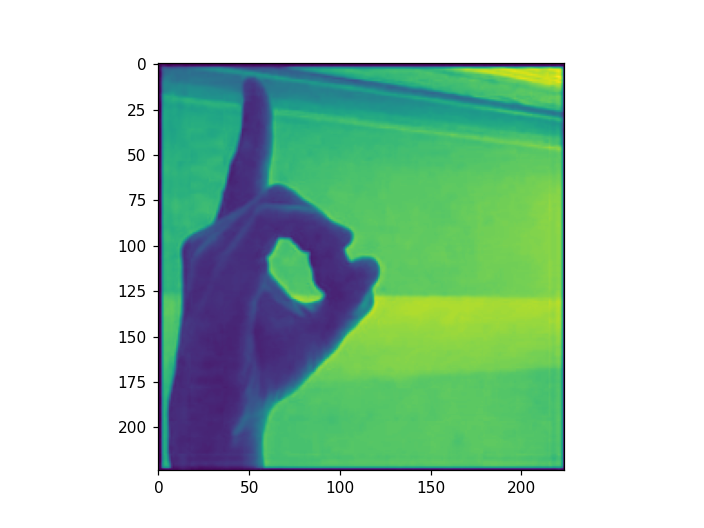

In [28]:
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1][0])
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1].numpy().transpose((0,2,1)))#.transpose(0,1))#.reshape(224,224,3))

<IPython.core.display.Javascript object>


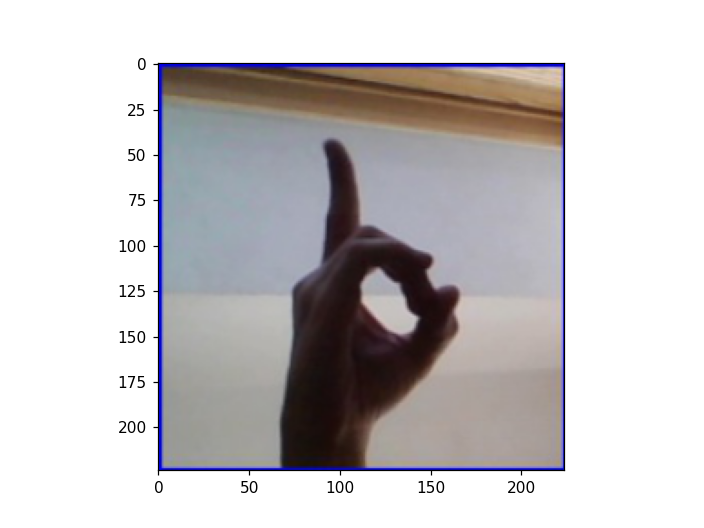

In [51]:
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1].numpy().transpose((1,2,0)))#.transpose(0,1))#.reshape(224,224,3))

<IPython.core.display.Javascript object>


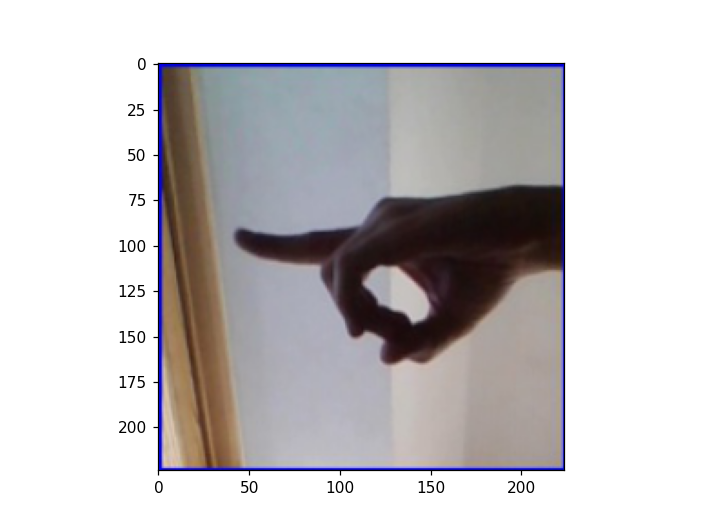

In [36]:
#bloque de comprension de donde queda la imagen 
iterable= iter(train_data_loader)
elemento_del_iterable = next(iterable) #contiene en el [0] los 16 ejemplos de las fotos y en el [1] las clases de estos
fig, ax = plt.subplots()
plt.imshow(elemento_del_iterable[0][1].transpose(0,2))#.reshape(224,224,3))

# creacion del modelo

In [ ]:
##CNN  SM  MLP_3: 

In [5]:
class OTT_Classifier(torch.nn.Module):
    
    def __init__(self):
        super(OTT_Classifier, self).__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=4, in_channels=3, out_channels=18)
        self.conv2 = torch.nn.Conv2d(kernel_size=4, in_channels=18, out_channels=45)
        self.mpool = torch.nn.MaxPool2d(kernel_size=2)
        self.activation = torch.nn.ReLU()
        self.activation2 = torch.nn.Softmax(dim=1)
        self.linear1 = torch.nn.Linear(in_features=16*53*53 ,out_features=120)
        self.linear2 = torch.nn.Linear(in_features=120 ,out_features=84)
        self.linear3 = torch.nn.Linear(in_features=84 ,out_features=4)
        
        pass
                     
    def forward(self, x):
        h = self.mpool((self.activation(self.conv1(x))))
        h = self.mpool((self.activation(self.conv2(h))))
        #print(h.shape)
        #view o reshape
        h = h.view(-1, self.linear1.in_features)
        h = self.activation(self.linear1(h))
        h = self.activation(self.linear2(h))
        h = self.activation2(self.linear3(h))
        return h
                     
                    
                     
     #hacer pasar un ejemplo 
#image = torch.tensor(np.zeros((1,3,200,200)), dtype= torch.float32) #fake example
model = OTT_Classifier()
display(model)
model.forward(OTT_valid_dataset[1][0].unsqueeze(0))#.size()                
                     
                     

OTT_Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (activation): ReLU()
  (activation2): Softmax(dim=1)
  (linear1): Linear(in_features=44944, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (linear3): Linear(in_features=84, out_features=4, bias=True)
)

tensor([[0.2567, 0.2465, 0.2575, 0.2394]], grad_fn=<SoftmaxBackward>)

# Entrenamiento

In [6]:
from ignite.engine import Engine, Events
from ignite.metrics import Loss, Accuracy

model = OTT_Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
max_epochs = 20  

#tensorboard --logdir=/tmp/tensorboard/


device = torch.device('cuda:0')
#device = torch.device('cuda:0')

model = model.to(device)

# Esto es lo que hace el engine de entrenamiento
def train_one_step(engine, batch):
    optimizer.zero_grad()
    x, y = batch
    x, y = x.to(device), y.to(device)
    yhat = model.forward(x)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    return loss.item() # Este output puede llamar luego como trainer.state.output

# Esto es lo que hace el engine de evaluación
def evaluate_one_step(engine, batch):
    with torch.no_grad():
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model.forward(x)
        #loss = criterion(yhat, y)
        return yhat, y

trainer = Engine(train_one_step)
evaluator = Engine(evaluate_one_step)
metrics = {'Loss': Loss(criterion), 'Acc': Accuracy()}
for name, metric in metrics.items():
    metric.attach(evaluator, name)

In [7]:
import time
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers import ModelCheckpoint

# Contexto de escritura de datos para tensorboard
with SummaryWriter(log_dir=f'/tmp/tensorboard/run{time.time_ns()}') as writer:

    @trainer.on(Events.EPOCH_COMPLETED(every=1)) # Cada 1 epocas
    def log_results(engine):
        # Evaluo el conjunto de entrenamiento
        evaluator.run(train_data_loader) 
        writer.add_scalar("train/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("train/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
        # Evaluo el conjunto de validación
        evaluator.run(valid_data_loader) 
        writer.add_scalar("valid/loss", evaluator.state.metrics['Loss'], engine.state.epoch)
        writer.add_scalar("valid/accy", evaluator.state.metrics['Acc'], engine.state.epoch)
    # Guardo el mejor modelo en validación
        print("epoch")
    best_model_handler = ModelCheckpoint(dirname='.', require_empty=False, filename_prefix="best", n_saved=1,
                                         score_function=lambda engine: -engine.state.metrics['Loss'],
                                         score_name="val_loss")

    # Lo siguiente se ejecuta cada ves que termine el loop de validación
    evaluator.add_event_handler(Events.COMPLETED, 
                                best_model_handler, {'ceroK': model})

    trainer.run(train_data_loader, max_epochs=max_epochs)

epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch
epoch


In [ ]:
eva

In [ ]:
OTT_train_dataset

In [ ]:
#modelo de entrenamiento base 

for epoch in range(num_epochs): # Durante un cierto número de épocas
        for minibatch in data: # Para cada minibatch de datos
            optimizer.zero_grad() # Limpiamos los gradientes
            x, y = minibatch # Desempaquetamos
            yhat = model.forward(x) # Predecimos
            loss = criterion(yhat, y) # Evaluamos
            loss.backward() # Calculamos los gradientes
            optimizer.step() # Actualizamos los parámetros

In [ ]:
#Metricas de modelo  #test #matriz de confusion #

In [18]:
modelo = OTT_Classifier()


In [19]:
modelo.load_state_dict(torch.load('./basura/best_lenet5_val_loss=-0.0336.pt'))

<All keys matched successfully>

In [21]:
modelo.load_state_dict(torch.load('./best_ceroK_val_loss=-0.0000.pt'))

<All keys matched successfully>

In [28]:
modelo.forward(OTT_test_dataset[31][0].unsqueeze(0))

tensor([[-408.5563, -116.3786, -204.5054,  -55.4185]], grad_fn=<AddmmBackward>)

In [27]:
OTT_test_dataset[31][1]

1

In [ ]:
#cross validation

In [ ]:
OTT_train_dataset[6000][1]

In [ ]:
#cybenkos?

In [ ]:
#bibliografia

#apis
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder
    
    
#tutoriales

https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0
    https://www.kaggle.com/androbomb/using-cnn-to-classify-images-w-pytorch 